In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
dataHHF = pd.read_csv('/Users/clara.henry/Documents/ElmerFiles/FilesForPaper/EvenHigherFriction/Vialov.csv')
dataHF = pd.read_csv('/Users/clara.henry/Documents/ElmerFiles/FilesForPaper/HigherFriction/Vialov.csv')

In [12]:
acc, A, n, rho, g = 1.2, 4.6e-25*1e8, 3.0, 900.0, 9.81
A0 = (2.0*A*(rho*g)**n)/5.0

def Summit(x, z):
    #h0 = (z**((2.0*n + 2.0)/n) + (2.0*(acc/(A0))**(1.0/n)) * x**((n + 1.0)/n))**(n/(2.0*n + 2.0))
    h0 = (z**((2.0*n + 2.0)/n) + (2.0*(acc/(2.0*A0))**(1.0/n)) * x**((n + 1.0)/n))**(n/(2.0*n + 2.0))
    return h0

def Height(h0, R):
    #h = (h0**((2.0*n + 2)/n) - (2.0*(acc/(A0))**(1.0/n))*(R**((n + 1.0)/n)))**(n/(2.0*n + 2.0))
    h = (h0**((2.0*n + 2)/n) - (2.0*(acc/(2.0*A0))**(1.0/n))*(R**((n + 1.0)/n)))**(n/(2.0*n + 2.0))
    return h

# Takes as input the data from a divide to grounding line cross-section
def Vialov(data, x, z, length):
    # Finds the coords of the maximum point in the data, to set where R=0
    IndexMaxHeight = 0
    zMaxPoint = 0
    xMaxPoint = 0
    yMaxPoint = 0

    for i in range(len(data)):
        if data['Points:2'][i] + 80 > zMaxPoint:
            xMaxPoint = data['Points:0'][i]
            yMaxPoint = data['Points:1'][i]
            zMaxPoint = data['Points:2'][i] + 80.0
            IndexHeighestPoint = i
    # Finds the indices of the surface coords
    IndicesSurface = []
    IndicesBase = []

    for i in range(len(data)):
        if data['depth'][i] < 0.01:
            IndicesSurface.append(i)

    for i in range(len(data)):
        if data['height'][i] < 0.01:
            IndicesBase.append(i)

    SurfaceElevation = []
    SurfaceDistances = []
    BaseElevation = []
    BaseDistances = []

    # 
    for i in IndicesSurface:
        SurfaceElevation.append(data['Points:2'][i] + 80)
        a = data['Points:0'][i]
        b = data['Points:1'][i]
        SurfaceDistances.append(np.sqrt((a - xMaxPoint)**2 + (b - yMaxPoint)**2))
        
    for i in IndicesBase:
        BaseElevation.append(data['Points:2'][i])
        a = data['Points:0'][i]
        b = data['Points:1'][i]
        BaseDistances.append(np.sqrt((a - xMaxPoint)**2 + (b - yMaxPoint)**2))
        
    ViaPlot = [[],[]]

    h0 = Summit(x, z)

    for R in range(0, length, 10):
        p = Height(h0, R)
        if p < 0:
            break
        ViaPlot[0].append(R/1000)
        ViaPlot[1].append(p - 80)
        
    dfS = pd.DataFrame({'Distances': SurfaceDistances, 'Heights':SurfaceElevation})
    dfS = dfS.sort_values(by=['Distances'])
    dfS = dfS.reset_index(drop=True)
    dfS['Distances'] = dfS['Distances']/1000
    dfS['Heights'] = dfS['Heights'] - 80
    
    dfB =  pd.DataFrame({'Distances': BaseDistances, 'Heights':BaseElevation})
    dfB = dfB.sort_values(by=['Distances'])
    dfB = dfB.reset_index(drop=True)
    dfB['Distances'] = dfB['Distances']/1000
    dfB['Heights'] = dfB['Heights']
    
    # Calculate top and bottom surfaces in the case of lower and higher friction

    M = 500.0
    b0 = -580.0
    sigma = 8.0
    x0 = (40000 - xMaxPoint)/1000

    X = np.arange(0, 60, 0.1)
    Z = []

    for x in X:
        Z.append(b0 + M * np.exp((-((x-x0)**2.0)**2)/(2.0*sigma**4)))

    BedrockGeometry = pd.DataFrame(list(zip(X, Z)), columns =['x', 'z'])
    

    return dfS['Distances'], dfS['Heights'], dfB['Distances'], dfB['Heights'], ViaPlot[0], ViaPlot[1], BedrockGeometry['x'], BedrockGeometry['z']

# HHF: h0 = Summit(6364, 94)
#  HF: h0 = Summit(8131, 106)

In [13]:
M = 500.0
b0 = -580.0
sigma = 8.0
x0 = 40.0

X = np.arange(0, 60.1, 0.1)
Z = []

for x in X:
    Z.append(b0 + M * np.exp((-((x-x0)**2.0)**2)/(2.0*sigma**4)))

BedrockGeometry = pd.DataFrame(list(zip(X, Z)), columns =['x', 'z'])

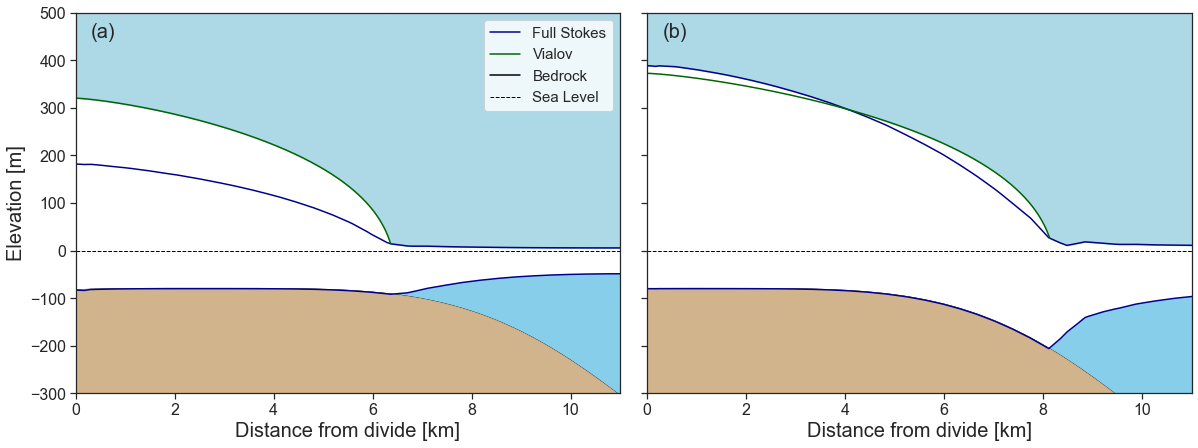

In [56]:
VialovHF = Vialov(dataHF, 6364, 94, 6364)
VialovHHF = Vialov(dataHHF, 8131, 106, 8131)

sns.set_theme(style="ticks")
fig, ax = plt.subplots(1, 2, figsize=(20,7), sharey='row')

ax[0].plot(VialovHF[0], VialovHF[1], label="Full Stokes", color='darkblue')
ax[0].plot(VialovHF[4], VialovHF[5], label='Vialov', color='darkgreen')
ax[0].plot(VialovHF[2], VialovHF[3], color='darkblue')
ax[0].plot(VialovHF[6], VialovHF[7], color='black', zorder=0, label='Bedrock')

ax[1].plot(VialovHHF[0], VialovHHF[1], color='darkblue')
ax[1].plot(VialovHHF[4], VialovHHF[5], label='Vialov', color='darkgreen')
ax[1].plot(VialovHHF[2], VialovHHF[3], color='darkblue')
ax[1].plot(VialovHHF[6], VialovHHF[7], color='black', zorder=0, label='Bedrock')

ax[0].fill_between(VialovHF[6], -750, VialovHF[7], color='tan')
ax[0].fill_between(VialovHF[6], -250, VialovHF[7], color='skyblue', zorder=0)
ax[0].fill_between(VialovHF[2], -250, VialovHF[3], color='skyblue', zorder=0)
ax[0].fill_between(VialovHF[4], 600, VialovHF[5], color='lightblue', zorder=0)
ax[0].fill_between(VialovHF[0][40:], 600, VialovHF[1][40:], color='lightblue', zorder=0)

ax[1].fill_between(VialovHHF[6], -750, VialovHHF[7], color='tan')
ax[1].fill_between(VialovHHF[6], -250, VialovHHF[7], color='skyblue', zorder=0)
ax[1].fill_between(VialovHHF[2], -250, VialovHHF[3], color='skyblue', zorder=0)
ax[1].fill_between(VialovHHF[0][:27], 600, VialovHHF[1][:27], color='lightblue', zorder=0)
ax[1].fill_between(VialovHHF[4][400:2000], 600, VialovHHF[5][400:2000], color='lightblue', zorder=0)
ax[1].fill_between(VialovHHF[0][48:], 600, VialovHHF[1][48:], color='lightblue', zorder=0)

ax[0].set_xlabel("Distance from divide [km]", fontsize=20)
ax[1].set_xlabel("Distance from divide [km]", fontsize=20)
ax[0].set_ylabel("Elevation [m]", fontsize=20)

ax[0].plot([0, 11], [0, 0], '--', lw=1, color='black', label='Sea Level')
ax[1].plot([0, 11], [0, 0], '--', lw=1, color='black')

#ax[0].plot([0, 0], [-300,500], ':', lw=1, color='black', label='Divide')
#ax[1].plot([0, 0], [-300,500], ':', lw=1, color='black')

ax[0].set_xlim(0,11)
ax[1].set_xlim(0,11)

ax[0].set_ylim(-300,500)
ax[1].set_ylim(-300,500)

ax[0].tick_params(axis="both", labelsize=16)
ax[1].tick_params(axis="both", labelsize=16)

ax[0].text(0.05, 0.95, '(a)', size=20, horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.05, 0.95, '(b)', size=20, horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)

ax[0].legend(fontsize='15', loc='upper right')
fig.subplots_adjust(hspace=0.15, wspace=0.05)
fig.savefig('VialovComparison.jpg', format='jpg', dpi=700, bbox_inches = "tight")